This Notebook provides a minimal example for using LFP to train a simple LeNet on MNIST.

For more complex examples, refer to the experiment notebooks in ./nbs

### Imports

In [ ]:
import os
import joblib
import random
import time

import numpy as np
import torch
import torch.nn as tnn
import torcheval.metrics
import torchvision.datasets as tvisiondata
import torchvision.transforms as T
from tqdm import tqdm

from lfprop.model.models import ACTIVATION_MAP

from lfprop.propagation import (
    propagator_lxt as propagator,
)  # LFP propagator
from lfprop.rewards import reward_functions as rewards  # Reward Functions
from lfprop.rewards import rewards as loss_fns
from torch_pso import ParticleSwarmOptimizer
from fa import *
from dladmm import dladmm 
from dladmm import input_data as dladmm_data

/home/lweber/.cache/pypoetry/virtualenvs/lfprop-KukTaqIE-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Parameters

In [ ]:
data_path = "your_data_path_here"  # Set your data path here
savepath = "your_save_path_here"  # Set your save path here
os.makedirs(savepath, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load Results

In [3]:
dirs = os.listdir(savepath)
print(dirs)

result_dict = {}
for dname in os.listdir(savepath):
    if dname.endswith(".svg"):
        continue
    model_name = dname.split("-")[-3]
    seed = int(dname.split("-")[-2])
    epochs = int(dname.split("-")[-1])

    method_name = ""
    for i in range(len(dname.split("-"))-3):
        method_name += dname.split("-")[i]
        if i < len(dname.split("-"))-4:
            method_name += "-"

    rpath = os.path.join(savepath, dname, "result_dict.joblib")

    if os.path.exists(rpath):
        if model_name not in result_dict.keys():
            result_dict[model_name] = {}
        if epochs not in result_dict[model_name].keys():
            result_dict[model_name][epochs] = {}
        if method_name not in result_dict[model_name][epochs].keys():
            result_dict[model_name][epochs][method_name] = []
        result_dict[model_name][epochs][method_name].append(joblib.load(rpath))

['vanilla-gradient-lenet-0-50', 'clock_times_mlp-50.svg', 'pso-mlp-13-50', 'pso-lenet-13-50', 'fa-mlp-13-50', 'fa-lenet-0-50', 'dladmm-mlp-13-50', 'vanilla-gradient-lenet-13-50', 'pso-lenet-13-20', 'vanilla-gradient-mlp-13-50', 'test_accuracies_mlp-50.svg', 'train_accuracies_mlp-50.svg', 'lfp-epsilon-lenet-0-50', 'lfp-epsilon-mlp-13-50', 'test_accuracies_over_clock_times_mlp-50.svg']


### Plots

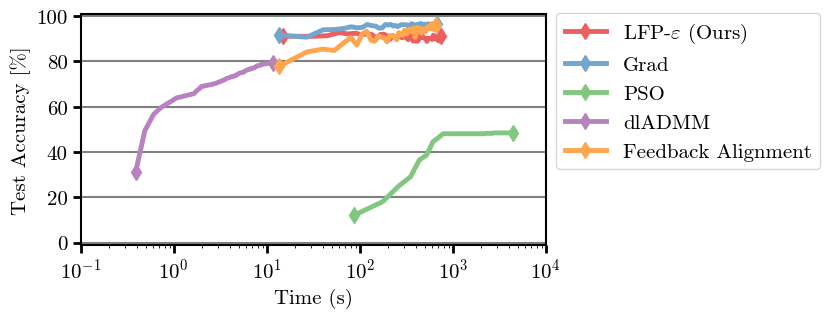

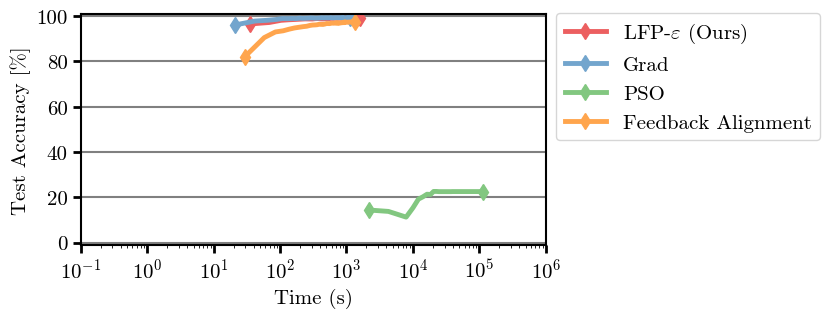

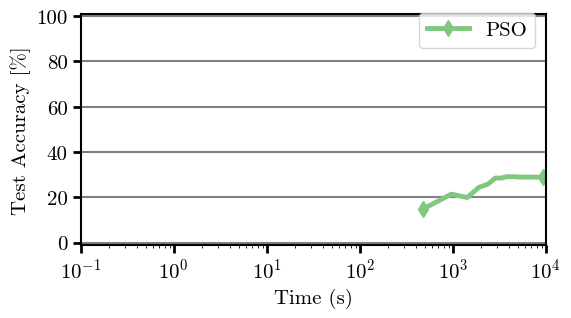

In [6]:
# Plot Settings
# Set font properties.
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.cm as cm
import copy
font_path = plt.matplotlib.get_data_path() + "/fonts/ttf/cmr10.ttf"
cmfont = font_manager.FontProperties(fname=font_path)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = cmfont.get_name()
plt.rcParams["mathtext.fontset"] = "cm"

# Set font size.
plt.rcParams["font.size"] = 15

# Disable unicode minus.
plt.rcParams["axes.unicode_minus"] = False

# Use mathtext for axes formatters.
plt.rcParams["axes.formatter.use_mathtext"] = True

plt.rcParams['axes.linewidth'] = 1.5

def generate_noise_label(apply_noise, noise_size):
    
    HATCHES = {
        0.1: ".",
        0.2: "x",
    }
    
    LINESTYLES = {
        0.1: "dotted",
        0.2: "dashed",
    }   
    
    MARKERSTYLES = {
        0.1: "D",
        0.2: "x",
    }   
    
    if not apply_noise:
        label = "No Noise"
        hatch = None
        linestyle = "solid"
        markerstyle = "."
        return label, hatch, linestyle, markerstyle
    else:
        label = f"Noise"# " + r"$\sigma=$" + f"{noise_size}"
        hatch = HATCHES[noise_size]
        linestyle = LINESTYLES[noise_size]
        markerstyle = MARKERSTYLES[noise_size]
        return label, hatch, linestyle, markerstyle

def plot_accs_over_epochs(eval_stats, fname, colormap="Set1"):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    colors = np.linspace(0, 1, 9)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.3
    palette = (1 - pastel) * palette + pastel * np.ones((9, 4))
    
    METHOD_LABELS = {
        "lfp-epsilon": r"LFP-$\varepsilon$",
        "vanilla-gradient": r"Grad",
    }

    barloc = 0.5
    xlabels = []
    for p, (prop_name, p_data) in enumerate(eval_stats.items()):
        for apply_noise in [False, True]:
            a_data = p_data[apply_noise]
            for noise_size, n_data in a_data.items():
                accuracy = n_data["test_accuracy"][-1]
                label, hatch, linestyle, markerstyle = generate_noise_label(apply_noise, noise_size)
        
                ax.bar(barloc, accuracy, color=palette[p], hatch=hatch)
                xlabels.append(f"{METHOD_LABELS[prop_name]} [{label}]")
                barloc += 1
        
    linelocs = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    ax.hlines(linelocs, xmin=-1, xmax=400, color=(0.5, 0.5, 0.5, 1), linewidth=1.5, zorder=0)

    ax.set_ylim([0.0, 1.0])
    ax.set_xlim([0, barloc-0.5])

    ax.set_ylabel(f"Test Accuracy [%]")
    ax.set_xlabel("")

    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([0, 20, 40, 60, 80, 100])

    ax.set_xticks(np.arange(0.5, barloc-0.5, 1.0))
    ax.set_xticklabels(xlabels, rotation=90)

    ax.tick_params(length=6, width=2)
    plt.show()
    fig.savefig(fname)

def plot_vals_over_epochs(eval_stats, fname, colormap="Set1", key="test_accuracy"):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))

    colors = np.linspace(0, 1, 9)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.3
    palette = (1 - pastel) * palette + pastel * np.ones((9, 4))
    
    KEY_LABELS = {
        "train_accuracy": "Train Accuracy [%]",
        "train_objective": "Train Objective",
        "test_accuracy": "Test Accuracy [%]",
        "test_objective": "Train Objective",
        "clock_time": "Time per Epoch (s)",
    }

    METHOD_LABELS = {
        "lfp-epsilon": r"LFP-$\varepsilon$",
        "vanilla-gradient": r"Grad",
        "pso": r"PSO",
        "dladmm": r"dlADMM",
        "fa": r"Feedback Alignment"
    }

    e_methods = [m for m in METHOD_LABELS.keys() if m in eval_stats.keys()]
    for p, method_name in enumerate(e_methods):
        p_data = eval_stats[method_name]
        plot_vals = []
        for s, seed_data in enumerate(p_data):
            plot_vals.append(seed_data[key])
        plot_means = np.mean(plot_vals, axis=0)

        xaxis = np.arange(0, len(plot_means))
        ax.plot(xaxis, plot_means, color=palette[p], label=METHOD_LABELS[method_name], linewidth=3.5, alpha=1)
        
    if "acc" in key:
        linelocs = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    else:
        step = ax.get_ylim()[1]/5
        linelocs = np.arange(0, ax.get_ylim()[1]+step, ax.get_ylim()[1]/4)
    ax.hlines(
        linelocs,
        xmin=-1,
        xmax=xaxis[-1],
        color=(0.5, 0.5, 0.5, 1),
        linewidth=1.5,
        zorder=0,
    )

    ax.set_ylabel(f"{KEY_LABELS[key]}")
    ax.set_xlabel("Epochs")
    ax.set_yticks(linelocs)
    if "acc" in key:
        ax.set_ylim([-0.01, 1.01])
        ax.set_yticklabels([0, 20, 40, 60, 80, 100])

    ax.set_xlim([0.0, xaxis[-1]])
    ax.tick_params(length=6, width=2)
    # ax.set_xlim([0, 200])
    ax.legend(bbox_to_anchor=(1, 0.5))
    plt.show()
    fig.savefig(fname)

def plot_vals_over_clocktime(eval_stats, fname, colormap="Set1", key="test_accuracy"):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))

    colors = np.linspace(0, 1, 9)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.3
    palette = (1 - pastel) * palette + pastel * np.ones((9, 4))
    
    KEY_LABELS = {
        "train_accuracy": "Train Accuracy [%]",
        "train_objective": "Train Objective",
        "test_accuracy": "Test Accuracy [%]",
        "test_objective": "Train Objective",
        "clock_time": "Time per Epoch (s)",
    }

    METHOD_LABELS = {
        "lfp-epsilon": r"LFP-$\varepsilon$ (Ours)",
        "vanilla-gradient": r"Grad",
        "pso": r"PSO",
        "dladmm": r"dlADMM",
        "fa": r"Feedback Alignment"
    }

    e_methods = [m for m in METHOD_LABELS.keys() if m in eval_stats.keys()]
    for p, method_name in enumerate(e_methods):
        p_data = eval_stats[method_name]
        plot_vals = []
        for s, seed_data in enumerate(p_data):
            plot_vals.append(seed_data[key])
        plot_means = np.mean(plot_vals, axis=0)

        times = []
        for s, seed_data in enumerate(p_data):
            tmp = seed_data["clock_time"]
            tmp_convolved = np.cumsum(tmp)
            times.append(tmp_convolved)
        tmp_convolved = np.mean(times, axis=0)

        ax.plot(tmp_convolved, plot_means, color=palette[list(METHOD_LABELS.keys()).index(method_name)], label=METHOD_LABELS[method_name], marker="d", markersize=8, markevery=len(tmp_convolved)-1, linewidth=3.5, alpha=1.0)
        
    if "acc" in key:
        linelocs = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    else:
        step = ax.get_ylim()[1]/5
        linelocs = np.arange(0, ax.get_ylim()[1]+step, ax.get_ylim()[1]/4)
        
    logxmax = 10 ** np.ceil(np.log10(ax.get_xlim()[1]))
        
    ax.hlines(
        linelocs,
        xmin=-1,
        xmax=logxmax,
        color=(0.5, 0.5, 0.5, 1),
        linewidth=1.5,
        zorder=0,
    )

    ax.set_ylabel(f"{KEY_LABELS[key]}")
    ax.set_xlabel("Time (s)")
    ax.set_yticks(linelocs)
    if "acc" in key:
        ax.set_ylim([-0.01, 1.01])
        ax.set_yticklabels([0, 20, 40, 60, 80, 100])

    #ax.set_xlim([0.0, tmp_convolved[-1]])
    ax.tick_params(length=6, width=2)
    ax.set_xlim([0.1, logxmax])
    ax.legend(bbox_to_anchor=(1.0, 1.05))
    ax.set_xscale("log")
    plt.show()
    fig.savefig(fname)

for model_name, model_res in result_dict.items():
    for epochs, e_res in result_dict[model_name].items():
        # plot_vals_over_epochs(e_res, os.path.join(savepath, f"test_accuracies_{model_name}-{epochs}.svg"), colormap="Set1", key="test_accuracy")
        # plot_vals_over_epochs(e_res, os.path.join(savepath, f"train_accuracies_{model_name}-{epochs}.svg"), colormap="Set1", key="train_accuracy")
        # plot_vals_over_epochs(e_res, os.path.join(savepath, f"clock_times_{model_name}-{epochs}.svg"), colormap="Set1", key="clock_time")
        plot_vals_over_clocktime(e_res, os.path.join(savepath, f"test_accuracies_over_clock_times_{model_name}-{epochs}.svg"), colormap="Set1", key="test_accuracy")